# Data processing

Load data from .dbc files and create reporting triangle and other covariate matrix

Start with single file

In [2]:
import numpy as np
import pandas as pd
#import pyreaddbc as rdbc

import subprocess


def dbc2csv(raw_filename):
    """ Function to convert .dbc file to .csv file
    Calls an R script to read and convert the file. Note that raw filename should NOT contain the .dbc suffix,
    it's added in the R script automatically for correct naming
    
    Args:
    raw_filename [str]: String name of file
    
    Returns:
    [bool]: status of conversion
    """
    dbc2csv_path = "./dbc2csv.R " + "../data/raw/Dengue/" + " " + "../data/derived/" + " " + raw_filename

    try:
        r_script_path = subprocess.getstatusoutput('which Rscript')[1]
        subprocess.call(r_script_path + " --vanilla " + dbc2csv_path, shell=True)
        return True
    except:
        print("(Rscript) Error converting file: " + raw_filename)

    return False

In [22]:
dbc2csv("DENGAC13") # works - can go through all codes and years and create csv files

Warnmeldung:
Paket ‘read.dbc’ wurde unter R Version 4.3.3 erstellt 


True

In [3]:
dengac13 = pd.read_csv("../data/derived/DENGAC13.csv", index_col=0)
dengac13

/var/folders/xr/mqd4g8995xqfhcvcyvr2smdc0000gn/T/ipykernel_39011/1820915393.py:1: DtypeWarning: Columns (57) have mixed types. Specify dtype option on import or set low_memory=False.
  dengac13 = pd.read_csv("../data/derived/DENGAC13.csv", index_col=0)


,TP_NOT,ID_AGRAVO,DT_NOTIFIC,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_SIN_PRI,...,LACO_N,PLASMATICO,EVIDENCIA,PLAQ_MENOR,CON_FHD,COMPLICA,TP_SISTEMA,NDUPLIC_N,CS_FLXRET,FLXRECEBI
1,2,A90,2013-01-08,201302,2013,12,120040,1938,2001527,2013-01-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0
2,2,A90,2013-01-10,201302,2013,12,120040,1938,2001527,2013-01-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0
3,2,A90,2013-01-06,201302,2013,12,120040,1938,2001527,2013-01-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0
4,2,A90,2013-01-06,201302,2013,12,120040,1938,2001527,2013-01-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0
5,2,A90,2013-01-11,201302,2013,12,120040,1938,2001527,2013-01-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9140,2,A90,2013-03-03,201310,2013,15,150145,1492,3738698,2013-02-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0
9141,2,A90,2013-01-25,201304,2013,11,110020,1483,2493896,2013-01-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0
9142,2,A90,2013-01-24,201304,2013,43,431490,1607,8011060,2013-01-22,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,0,2.0
9143,2,A90,2013-12-17,201351,2013,42,420930,1571,6494633,2013-12-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0


DT_NOTIFIC is the date of reporting (in system), DT_SIN_PRI is either date of symptoms or true date of test, so the date the nowcast should be applied to.

Group observations by DT_SIN_PRI and then count the number of observations per number of delays (DT_NOTIFIC - DT_SIN_PRI), probably convert to datetime

In [4]:
from datetime import datetime # for conversion of date differences to days
date_format = "%Y-%m-%d"
dengac13['DT_NOTIFIC'] = pd.to_datetime(dengac13['DT_NOTIFIC'], format=date_format)
dengac13['DT_SIN_PRI'] = pd.to_datetime(dengac13['DT_SIN_PRI'], format=date_format)

# Calculate the delay in days and add it as a new column
dengac13['delay'] = (dengac13['DT_NOTIFIC'] - dengac13['DT_SIN_PRI']).dt.days


In [5]:
dengac13

,TP_NOT,ID_AGRAVO,DT_NOTIFIC,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_SIN_PRI,...,PLASMATICO,EVIDENCIA,PLAQ_MENOR,CON_FHD,COMPLICA,TP_SISTEMA,NDUPLIC_N,CS_FLXRET,FLXRECEBI,delay
1,2,A90,2013-01-08,201302,2013,12,120040,1938,2001527,2013-01-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,2
2,2,A90,2013-01-10,201302,2013,12,120040,1938,2001527,2013-01-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,7
3,2,A90,2013-01-06,201302,2013,12,120040,1938,2001527,2013-01-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,3
4,2,A90,2013-01-06,201302,2013,12,120040,1938,2001527,2013-01-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,3
5,2,A90,2013-01-11,201302,2013,12,120040,1938,2001527,2013-01-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9140,2,A90,2013-03-03,201310,2013,15,150145,1492,3738698,2013-02-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,3
9141,2,A90,2013-01-25,201304,2013,11,110020,1483,2493896,2013-01-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,7
9142,2,A90,2013-01-24,201304,2013,43,431490,1607,8011060,2013-01-22,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,0,2.0,2
9143,2,A90,2013-12-17,201351,2013,42,420930,1571,6494633,2013-12-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,14


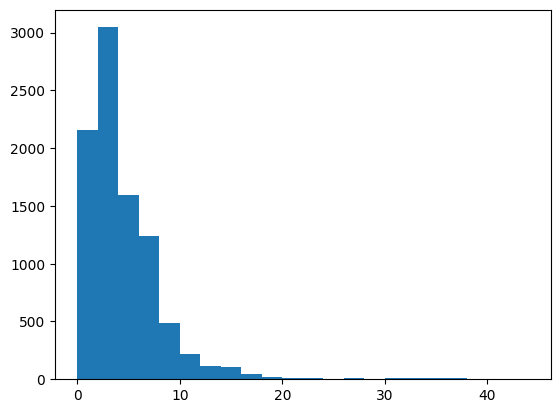

In [6]:
import matplotlib.pyplot as plt
plt.hist(dengac13.delay, bins = np.arange(0, 45, 2))
plt.show()

So 40-45 delays will contain virtually all values, enough to bin there

In [7]:
len(dengac13[dengac13.delay == 0])/len(dengac13) # only 8.5% report on original day, rest later, need to nowcast

0.0857392825896763

For each date must take into account that all dates up to that one will include reports for past days, so per t have reporting triangle shifting

## Create reporting triangle

Probably easiest as function with current date, then populate back maybe 60 days, 40 max delay, output matrix

In [58]:
delay_df = dengac13.groupby('DT_SIN_PRI')['delay'].apply(lambda x: x.value_counts().reindex(range(46))).unstack(fill_value=0)

# Rename columns to reflect delays
delay_df.columns = [f'delay_{col}' for col in delay_df.columns]

# Reset index to move 'DT_SIN_PRI' back to a column
delay_df.reset_index(inplace=True)

delay_df.fillna(0, inplace=True)
delay_df # correct length

,DT_SIN_PRI,delay_0,delay_1,delay_2,delay_3,delay_4,delay_5,delay_6,delay_7,delay_8,...,delay_36,delay_37,delay_38,delay_39,delay_40,delay_41,delay_42,delay_43,delay_44,delay_45
0,2012-12-30,3.0,15.0,13.0,5.0,5.0,5.0,5.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012-12-31,2.0,9.0,12.0,6.0,13.0,5.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-01,2.0,7.0,12.0,8.0,1.0,0.0,4.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-01-02,3.0,14.0,11.0,8.0,1.0,3.0,3.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-01-03,6.0,8.0,5.0,8.0,7.0,5.0,5.0,10.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,2013-12-23,0.0,0.0,0.0,1.0,2.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
358,2013-12-24,0.0,1.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,2013-12-25,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
360,2013-12-26,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
delay_df["total"] = delay_df[list(delay_df.columns[1:])].sum(axis=1)

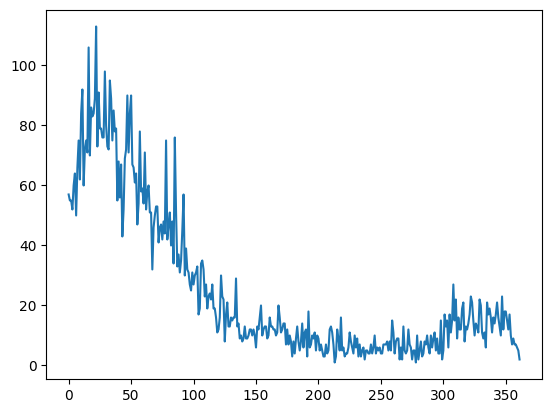

In [60]:
plt.plot(delay_df["total"])

In [146]:
def reporting_triangle(date, past_days = 60, max_delay = 45, array = False):
    result_df = dengac13.groupby('DT_SIN_PRI')['delay'].apply(lambda x: x.value_counts().reindex(range(max_delay+1))).unstack(fill_value=0)

    # Rename columns to reflect delays
    result_df.columns = [f'delay_{col}' for col in result_df.columns]

    # Reset index to move 'DT_SIN_PRI' back to a column
    result_df.reset_index(inplace=True)

    result_df.fillna(0, inplace=True)
    result_df = result_df[result_df.DT_SIN_PRI <= date].iloc[-past_days:, :].reset_index()# correct length

    ## Mask lower triangle bc not reported
    result_df.drop("index", axis = 1, inplace=True)
    if array: return np.array(result_df.iloc[:, 1:].values, dtype = np.float32) # need float32 for PyTorch
    else: return result_df

    

In [147]:
triangle = reporting_triangle("2013-12-27", array=True)
triangle

array([[2., 1., 4., ..., 0., 0., 0.],
       [0., 2., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 4., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.]], dtype=float32)

In [148]:
triangle.shape

(60, 46)

In [155]:
import torch
from torch.utils.data import Dataset, DataLoader

class TriangleDataset(Dataset):
    ## Theoretically, should contain covariates for date too, return tuple of matrix and covariates as well as label at each iteration

    def __init__(self, start_date, end_date, past_days=45, max_delay=45, device = "mps"):
        """
        Initialize the dataset with a start and end date.
        The dataset will generate matrices for each date within this range.
        
        Parameters:
        - start_date: The start date for generating matrices.
        - end_date: The end date for generating matrices.
        - past_days: Number of past days to consider for each matrix.
        - max_delay: Maximum delay to consider for each matrix.
        """
        self.start_date = start_date
        self.end_date = end_date
        self.past_days = past_days
        self.max_delay = max_delay
        self.device = device
    
    def __len__(self):
        # Calculate the number of days between 60 days after start_date and 46 days before end_date
        start_offset = pd.DateOffset(days=self.past_days)
        end_offset = pd.DateOffset(days= - self.max_delay - 1)
        # Apply the offsets correctly
        start_date_plus_offset = self.start_date + start_offset
        end_date_minus_offset = self.end_date + end_offset
        # Now calculate the difference in days
        return (end_date_minus_offset - start_date_plus_offset).days
    
    def __getitem__(self, idx):
        # Calculate the date for the current iteration, considering the adjusted range
        date = self.start_date + pd.DateOffset(days=self.past_days) + pd.DateOffset(days=idx)
        
        # Check if the calculated date is still within the valid range
        if date > self.end_date:
            raise IndexError("Index out of range")
        
        # Generate the matrix for the current date
        matrix = reporting_triangle(date, past_days=self.past_days, max_delay=self.max_delay, array=True)
        
        # Convert the matrix to a PyTorch tensor
        tensor = torch.from_numpy(matrix)
        tensor = tensor.to(device=self.device)
        
        # Compute the sum of the delays for the current date (row sum)
        label = torch.sum(tensor[-1, :], dtype=torch.float32)
        #label.to(self.device)
        #print(tensor.device)
        #print(label.get_device())
        return tensor, label

In [156]:
start_date = pd.Timestamp('2012-12-30')
end_date = pd.Timestamp('2013-12-27')
dataset = TriangleDataset(start_date, end_date, past_days=45, max_delay=45)

# Accessing an item from the dataset
try:
    item = dataset[0]
    print(item)
    print(item[0][-1, :].sum())
except IndexError as e:
    print(e)

(tensor([[ 2.,  9., 12.,  ...,  0.,  0.,  0.],
        [ 2.,  7., 12.,  ...,  0.,  0.,  0.],
        [ 3., 14., 11.,  ...,  0.,  0.,  0.],
        ...,
        [ 1.,  1.,  7.,  ...,  0.,  0.,  0.],
        [ 1.,  7.,  9.,  ...,  0.,  0.,  0.],
        [ 1., 14., 14.,  ...,  0.,  0.,  0.]], device='mps:0'), tensor(69., device='mps:0'))
tensor(69., device='mps:0')


In [157]:
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Iterate over the dataloader to access batches of data
"""for batch_idx, (inputs, labels) in enumerate(dataloader):
    print(f"Batch {batch_idx}: Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")"""

'for batch_idx, (inputs, labels) in enumerate(dataloader):\n    print(f"Batch {batch_idx}: Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")'

In [172]:
test_tensor = torch.from_numpy(np.array([[1,2], [3,4]]))
test_tensor.flatten()

tensor([1, 2, 3, 4])

In [158]:
import torch.nn as nn
from torch.masked import masked_tensor

class BLLNowcaster(nn.Module):
    def __init__(self, past_days = 45, max_delay = 45):
        super().__init__()
        self.past_days = past_days
        self.max_delay = max_delay
        self.conv1 = nn.Conv1d(self.max_delay+1, 32, 1)
        self.conv2 = nn.Conv1d(32, 16, 1)
        self.conv3 = nn.Conv1d(16, 1, 1)
        self.fc = nn.Linear(self.past_days, 1)
        self.softplus = nn.Softplus()
    
    def mask(self, batch_size):
        mask = torch.zeros((self.past_days, self.max_delay+1), dtype=torch.bool)
        for p in range(self.past_days):
            for d in range(self.max_delay + 1):
                if p + d >= self.max_delay:
                    mask[p, d] = True
        return mask.unsqueeze(0).repeat(batch_size, 1, 1)
        #return torch.tile(mask, (batch_size, self.past_days, self.max_delay+1))
    
    def forward(self, x):
        #forward_mask = self.mask(x.shape[0])
        #print(x.shape, forward_mask.shape)
        #x = masked_tensor(x, self.mask(x.shape[0]))
        x = torch.transpose(x, 1, 2)
        #print(x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.squeeze(x)
        x = self.fc(x)
        x = torch.squeeze(x)
        pois = torch.distributions.Poisson(self.softplus(x))
        return torch.distributions.Independent(pois, reinterpreted_batch_ndims=1)
    

In [161]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

def train(model, num_epochs, loader, device = torch.device("mps")):
    model.to(device)
    #loader.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

    for e in range(num_epochs):
        batch_loss = 0.

        for mat, y in loader:
            #print(f"Devices: Model {next(model.parameters()).device} mat {mat.get_device()} y {y.get_device()}")
            #mat.to(device)
            #y = torch.tensor(y, dtype = torch.float32)
            #y.to(device)
            model.train()

            optimizer.zero_grad()
            dist_pred = model(mat)
            #print(f"Outcome: {y} | Predicted: {dist_pred}")
            loss = nll(y, dist_pred).mean()
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
        
        batch_loss /= len(loader)

        #if e % 50 == 0 or e == num_epochs-1:
        print(f"Epoch {e+1} - Train loss: {batch_loss:.3}")

In [162]:
bll_nowcaster = BLLNowcaster(past_days=45, max_delay=45)
train(bll_nowcaster, 10, dataloader)

Epoch 1 - Train loss: 9.04e+02
Epoch 2 - Train loss: 8.85e+02
Epoch 3 - Train loss: 8.51e+02
Epoch 4 - Train loss: 6.9e+02
Epoch 5 - Train loss: 3.51e+02
Epoch 6 - Train loss: 1.46e+02
Epoch 7 - Train loss: 72.6
Epoch 8 - Train loss: 56.2
Epoch 9 - Train loss: 54.4
Epoch 10 - Train loss: 54.3


In [163]:
plotloader = DataLoader(dataset, batch_size=len(delay_df), shuffle=False)

In [169]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1
mat, y = next(iter(plotloader))
mat, y = mat.to("cpu"), y.to("cpu")
y_atm = mat[:, -1, 0].numpy()
#preds = bll_nowcaster(mat).sample()
n_samples = 100
preds = np.zeros((y.shape[0], n_samples))
bll_nowcaster = bll_nowcaster.to("cpu")
for i in range(n_samples):
    preds[:, i] = bll_nowcaster(mat).sample().numpy()
preds_mean = np.mean(preds, axis=1)
lower_ci = np.quantile(preds, 0.025, 1)
upper_ci = np.quantile(preds, 0.975, 1)

env: PYTORCH_ENABLE_MPS_FALLBACK=1


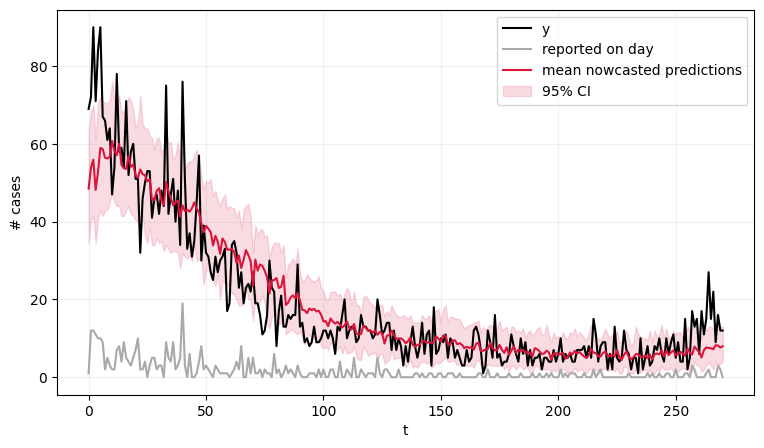

In [171]:
plt.figure(figsize=(9, 5))
plt.plot(y, label="y", c = "black")
plt.plot(y_atm, label="reported on day", c = "darkgrey")
plt.plot(preds_mean, label = "mean nowcasted predictions", c = "crimson")
plt.fill_between(range(len(y_atm)),lower_ci, upper_ci, color = "crimson", alpha = 0.15, label = "95% CI")
plt.grid(alpha=.2)
plt.legend()
plt.ylabel("# cases")
plt.xlabel("t")
plt.savefig("../outputs/figures/simple_forecast")
plt.show()